In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import scipy.stats

In [2]:
q = data_frame = pd.read_parquet("relevance_challenge_train-001.parquet")

q.head()

,text,coordinates,label,raw_prediction,confidence,distance
20964,@joel271161 @poulin2012 vous êtes tellement fa...,"[0.695310096918557, 43.50579007522291]",721,"[-1.8304776, -1.6434574, -1.0601386, -1.431044...",0.032404,432.374286
448207,@sighutsu @blue01530961 那以前比較可以天天撿到幸運草～,"[121.39972544895538, 24.845272660654956]",953,"[-0.18133685, 0.07034852, 0.40745744, -0.15412...",0.254868,31.319643
497842,precisando viajar,"[-38.9130606409334, -13.071335826421613]",133,"[3.215739, -1.3704515, -0.6494701, -1.4568123,...",0.016078,1194.078186
453073,@memorylanerv @emc_maine @oh_grow_on @gardenin...,"[-82.8151652958084, 39.99343560927911]",1511,"[0.23749076, -0.8375926, 0.8497064, 1.0164264,...",0.387185,1114.610179
366398,@inemexico como que no son muy puntuales para ...,"[-103.47883507502031, 21.038488711387007]",129,"[-3.4438925, -2.687308, -0.7648393, -1.0434728...",0.057140,486.739171


In [5]:
y = q['distance']

In [8]:
X = np.stack(q['raw_prediction'])
from scipy.special import softmax


In [7]:

# Basic statistical features
mean_confidence = np.mean(X, axis=1)
std_confidence = np.std(X, axis=1)
max_confidence = np.max(X, axis=1)
min_confidence = np.min(X, axis=1)
sum_confidence = np.sum(X, axis=1)
median_confidence = np.median(X, axis=1)

# Additional percentiles
percentile_25 = np.percentile(X, 25, axis=1)
percentile_75 = np.percentile(X, 75, axis=1)
percentile_10 = np.percentile(X, 10, axis=1)
percentile_90 = np.percentile(X, 90, axis=1)

# Indices (positions) of max, min, median
argmax_confidence = np.argmax(X, axis=1)
argmin_confidence = np.argmin(X, axis=1)
argmedian_confidence = np.argmin(np.abs(X - np.median(X, axis=1, keepdims=True)), axis=1)

# Skewness and Kurtosis
skew_confidence = np.apply_along_axis(lambda x: scipy.stats.skew(x), axis=1, arr=X)
kurtosis_confidence = np.apply_along_axis(lambda x: scipy.stats.kurtosis(x), axis=1, arr=X)

# Range (max - min)
range_confidence = max_confidence - min_confidence

# Mean Absolute Deviation (MAD)
mad_confidence = np.mean(np.abs(X - np.mean(X, axis=1, keepdims=True)), axis=1)



# Cumulative Sum and Product
cumulative_sum_confidence = np.cumsum(X, axis=1).mean(axis=1)

# Difference Between Consecutive Features and Moving Average
difference_confidence = np.diff(X, axis=1).mean(axis=1)


# Softmax operation
softmax_confidence = softmax(X, axis=1)

# Taking top 5 values after Softmax
top_5_softmax = np.sort(softmax_confidence, axis=1)[:, -5:]

# Features for each of the top 5 softmax values
top_1_softmax = top_5_softmax[:, -1]
top_2_softmax = top_5_softmax[:, -2]
top_3_softmax = top_5_softmax[:, -3]
top_4_softmax = top_5_softmax[:, -4]
top_5_softmax = top_5_softmax[:, -5]

# Combine all features into a single 2D array
new_features = np.column_stack(
    (mean_confidence, std_confidence, max_confidence, min_confidence, sum_confidence, 
     median_confidence, percentile_25, percentile_75, percentile_10, percentile_90, 
     argmax_confidence, argmin_confidence, argmedian_confidence, skew_confidence, kurtosis_confidence, 
     range_confidence, mad_confidence, cumulative_sum_confidence, difference_confidence,
    top_1_softmax, top_2_softmax, top_3_softmax, top_4_softmax, top_5_softmax))





NameError: name 'softmax' is not defined

In [37]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from textblob import TextBlob
import textstat
from gensim.models import Word2Vec
from collections import Counter

# Ensure the necessary NLTK data is downloaded
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')

def extract_features(df, text_column):
    # Helper functions for different features
    def length_based_features(text):
        chars = len(text)
        words = len(text.split())
        avg_word_length = chars / words if words else 0
        return [chars, words, avg_word_length]

    def pos_features(text):
        words = nltk.word_tokenize(text)
        pos_tags = nltk.pos_tag(words)
        pos_counts = Counter(tag for word, tag in pos_tags)
        return list(pos_counts.values())

    def ner_features(text):
        words = nltk.word_tokenize(text)
        pos_tags = nltk.pos_tag(words)
        named_ents = nltk.ne_chunk(pos_tags, binary=True)
        return len([chunk for chunk in named_ents if hasattr(chunk, 'label') and chunk.label() == 'NE'])

    def sentiment_score(text):
        return TextBlob(text).sentiment.polarity

    def readability_scores(text):
        flesch_reading = textstat.flesch_reading_ease(text)
        gunning_fog = textstat.gunning_fog(text)
        return [flesch_reading, gunning_fog]

    # Initialize lists to store each feature
    lengths, sentiments, readabilities, ners = [], [], [], []

    # Iterate through each text entry and extract features
    for text in df[text_column]:
        lengths.append(length_based_features(text))
        sentiments.append(sentiment_score(text))
        readabilities.append(readability_scores(text))
        ners.append(ner_features(text))

    # Convert lists to NumPy arrays
    lengths = np.array(lengths)
    sentiments = np.array(sentiments).reshape(-1, 1)
    readabilities = np.array(readabilities)
    ners = np.array(ners).reshape(-1, 1)

    # Concatenate all features into a single array
    features = np.concatenate([lengths, sentiments, readabilities, ners], axis=1)

    return features


text_features = extract_features(q, 'text')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/brazhenko/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/brazhenko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/brazhenko/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/brazhenko/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [39]:
combined_features = np.column_stack([new_features, text_features])

In [40]:
import numpy as np

# Assuming 'your_array' is your NumPy array
your_array = np.array(...)  # Replace with your actual array

# Function to check if a column contains only finite values
def has_only_finite_values(column):
    return np.all(np.isfinite(column))

# Identify columns that do not contain only finite values
columns_with_non_finite_values = [i for i in range(combined_features.shape[1]) if not has_only_finite_values(combined_features[:, i])]

print("Columns with non-finite values:", columns_with_non_finite_values)


Columns with non-finite values: []


In [41]:
combined_features.shape

(498150, 31)

In [42]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [43]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, y, test_size=0.2, random_state=42)


In [44]:
import xgboost as xgb


In [57]:

# Create and Train XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=10, random_state=42)
xgb_model.fit(X_train, y_train)

# Make Predictions and Evaluate the Model
y_pred = xgb_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse, r2)

9683240.870547267 0.4463995378807596


In [58]:

from joblib import dump
dump(xgb_model, 'xgboost_model.joblib')


['xgboost_model.joblib']

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

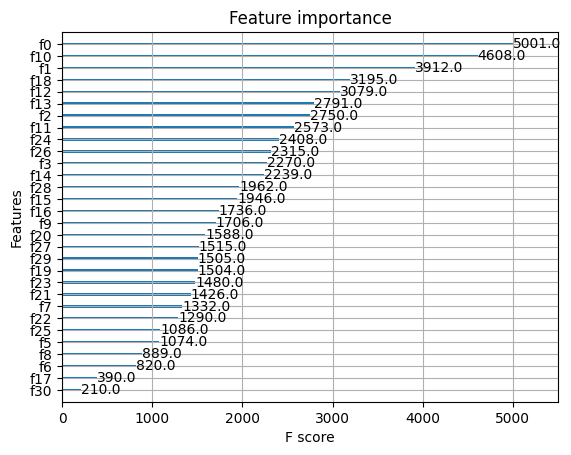

In [52]:
xgb.plot_importance(xgb_model)